In [6]:
import math

In [7]:

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

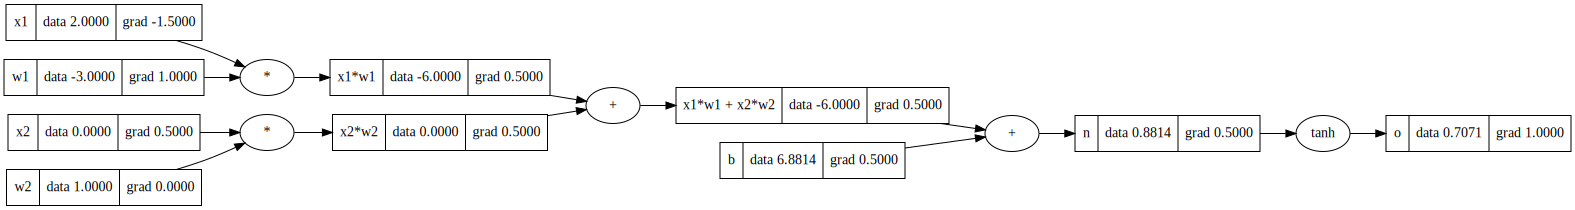

In [ ]:
draw_dot(o)

In [10]:
import random

class Neuron:
  def __init__(self,numInputs):
    self.w = [Value(random.uniform(-1,1) for i in range(numInputs))]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum( (wi * xi for wi, xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameter(self):
    return self.w + [self.b]


class Layer:
  def __init__(self,numInputs,numLayers):
    self.neurons = [Neuron(numInputs) for _ in range(numLayers)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameter(self):
    return [p for neuron in self.neurons for p in neuron.parameter()]

class MLP:
  def __init__(self,numInputs,numOutputLayers):
    sz = [numInputs] + numOutputLayers
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(numOutputLayers))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameter(self):
    return [p for layer in self.layers for p in layer.parameter()]

In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.4169008461821443)

In [12]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [15]:
for k in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)


0 0.04770660612934987
1 0.04740863553028283
2 0.04711416205355875
3 0.04682312630797196
4 0.04653547021267941
5 0.04625113696180909
6 0.04597007099019406
7 0.04569221794019288
8 0.045417524629555554
9 0.04514593902029865
10 0.04487741018855123
11 0.044611888295338784
12 0.04434932455827041
13 0.04408967122409724
14 0.04383288154211201
15 0.04357890973835973
16 0.04332771099063023
17 0.04307924140420735
18 0.042833457988346146
19 0.04259031863345489
20 0.04234978208895607
21 0.04211180794180412
22 0.041876356595637904
23 0.04164338925054479
24 0.041412867883416755
25 0.04118475522887933
26 0.040959014760772086
27 0.04073561067416473
28 0.0405145078678885
29 0.04029567192756889
30 0.04007906910913947
31 0.03986466632282518
32 0.039652431117575854
33 0.039442331665938066
34 0.03923433674935057
35 0.03902841574384809
36 0.0388245386061634
37 0.03862267586021145
38 0.038422798583946594
39 0.03822487839657862
40 0.03802888744613832
41 0.037834798397379715
42 0.037642584420010186
43 0.0374522

In [16]:
ypred

[Value(data=0.9016395645259554),
 Value(data=-0.9753308080008101),
 Value(data=-0.8690801111702803),
 Value(data=0.9055326822201999)]